In [ ]:
# ! git clone https://github.com/krasserm/super-resolution.git

Cloning into 'super-resolution'...
remote: Enumerating objects: 405, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 405 (delta 9), reused 19 (delta 8), pack-reused 385
Receiving objects: 100% (405/405), 54.27 MiB | 27.70 MiB/s, done.
Resolving deltas: 100% (209/209), done.


In [ ]:
!unzip super-resolution.zip

Archive:  super-resolution.zip
 extracting: super-resolution/.gitignore  
  inflating: super-resolution/article.ipynb  
  inflating: super-resolution/data.py  
   creating: super-resolution/demo/
  inflating: super-resolution/demo/0829x4-crop.png  
  inflating: super-resolution/demo/0851x4-crop.png  
  inflating: super-resolution/demo/0869x4-crop.png  
   creating: super-resolution/docs/
   creating: super-resolution/docs/images/
  inflating: super-resolution/docs/images/figure_1.png  
  inflating: super-resolution/docs/images/figure_2.png  
  inflating: super-resolution/docs/images/figure_3.png  
  inflating: super-resolution/docs/images/figure_4.png  
  inflating: super-resolution/docs/images/figure_5.png  
  inflating: super-resolution/docs/images/figure_6.png  
  inflating: super-resolution/docs/images/result-edsr.png  
  inflating: super-resolution/docs/images/result-srgan.png  
  inflating: super-resolution/docs/images/result-wdsr.png  
  inflating: super-resolution/environment.y

In [ ]:
%cd super-resolution

/content/super-resolution


In [ ]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.srgan import generator, discriminator
from train import SrganTrainer, SrganGeneratorTrainer

%matplotlib inline

In [ ]:
# Location of model weights (needed for demo)
weights_dir = 'weights/srgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)

os.makedirs(weights_dir, exist_ok=True)

In [ ]:
div2k_train = DIV2K(scale=4, subset='train', downgrade='bicubic')
div2k_valid = DIV2K(scale=4, subset='valid', downgrade='bicubic')



In [ ]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=16, random_transform=True, repeat_count=1)

In [ ]:
from model.srgan import generator
from train import SrganGeneratorTrainer

# Create a training context for the generator (SRResNet) alone.
pre_trainer = SrganGeneratorTrainer(model=generator(), checkpoint_dir=f'.ckpt/pre_generator')

# Pre-train the generator with 1,000,000 steps (100,000 works fine too). 
pre_trainer.train(train_ds, valid_ds.take(10), steps=1000, evaluate_every=100)

# Save weights of pre-trained generator (needed for fine-tuning with GAN).
pre_trainer.model.save_weights('weights/srgan/pre_generator.h5')

100/1000: loss = 1625.347, PSNR = 4.536240 (360.91s)
200/1000: loss = 854.147, PSNR = 4.890979 (354.68s)
300/1000: loss = 720.911, PSNR = 7.683389 (335.22s)
400/1000: loss = 729.874, PSNR = 5.094146 (343.44s)
500/1000: loss = 662.076, PSNR = 7.660897 (341.40s)
600/1000: loss = 546.295, PSNR = 5.667291 (341.92s)
700/1000: loss = 488.832, PSNR = 5.283753 (343.63s)
800/1000: loss = 465.323, PSNR = 7.532497 (341.96s)
900/1000: loss = 426.211, PSNR = 6.866771 (342.70s)
1000/1000: loss = 413.483, PSNR = 5.266156 (342.60s)


In [ ]:
from model.srgan import generator, discriminator
from train import SrganTrainer

# Create a new generator and init it with pre-trained weights.
gan_generator = generator()
gan_generator.load_weights('weights/srgan/pre_generator.h5')

# Create a training context for the GAN (generator + discriminator).
gan_trainer = SrganTrainer(generator=gan_generator, discriminator=discriminator())

# Train the GAN with 200,000 steps.
gan_trainer.train(train_ds, steps=2000)

# Save weights of generator and discriminator.
gan_trainer.generator.save_weights('weights/srgan/gan_generator.h5')
gan_trainer.discriminator.save_weights('weights/srgan/gan_discriminator.h5')

80142336/80134624 [==============================] - 1s 0us/step
50/2000, perceptual loss = 0.1835, discriminator loss = 1.4175
100/2000, perceptual loss = 0.1675, discriminator loss = 0.7150
150/2000, perceptual loss = 0.1698, discriminator loss = 0.4187
200/2000, perceptual loss = 0.1735, discriminator loss = 0.3482
250/2000, perceptual loss = 0.1626, discriminator loss = 0.2417
300/2000, perceptual loss = 0.1728, discriminator loss = 0.2653
350/2000, perceptual loss = 0.1626, discriminator loss = 0.2624
400/2000, perceptual loss = 0.1601, discriminator loss = 0.4069
450/2000, perceptual loss = 0.1630, discriminator loss = 0.4781
500/2000, perceptual loss = 0.1584, discriminator loss = 0.3443
550/2000, perceptual loss = 0.1542, discriminator loss = 0.3681
600/2000, perceptual loss = 0.1519, discriminator loss = 0.1794
650/2000, perceptual loss = 0.1588, discriminator loss = 0.5235
700/2000, perceptual loss = 0.1497, discriminator loss = 0.1966
750/2000, perceptual loss = 0.1479, disc

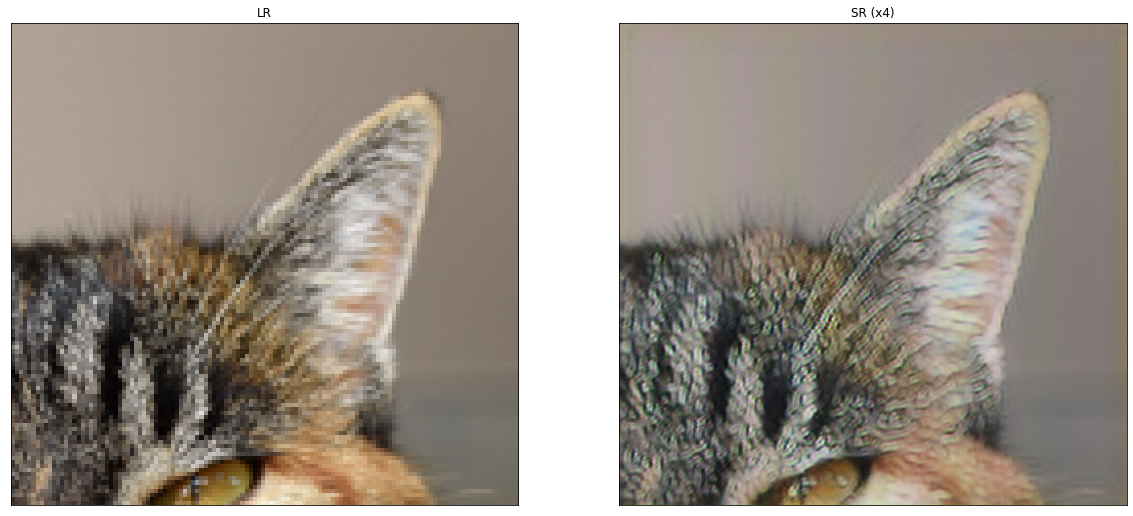

In [ ]:
from model.srgan import generator
from model import resolve_single
from utils import load_image, plot_sample

model = generator()
model.load_weights('weights/srgan/gan_generator.h5')


lr = load_image('demo/0869x4-crop.png')
sr = resolve_single(model, lr)



plot_sample(lr, sr)

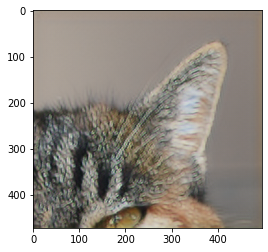

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(sr)



In [ ]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_model_size = open("/content/super-resolution/weights/srgan/srgan.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp8e3shuwn/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# A generator that provides a representative dataset

def representative_data_gen():
  ds = div2k_train.lr_dataset()
  ds = ds.take(100)
  for image in ds:
    image = tf.image.resize(image, [image.shape[0], image.shape[1]])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]


# ds = div2k_train.lr_dataset()
# ds = ds.take(1)
# for image in ds:
#     image = tf.image.resize(image, [image.shape[0], image.shape[1]])
#     image = tf.cast(image / 255., tf.float32)
#     image = tf.expand_dims(image, 0)
#     print(image)


In [ ]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

import os
import numpy as np
import matplotlib.pyplot as plt

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

tflite_model_size = open("/content/super-resolution/weights/srgan/srgan_quant_2.tflite", "wb").write(tflite_model)
print("Quantized model is %d bytes" % tflite_model_size)

INFO:tensorflow:Assets written to: /tmp/tmpxs_tu_pw/assets


INFO:tensorflow:Assets written to: /tmp/tmpxs_tu_pw/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Quantized model is 1656848 bytes


(24, 24, 3)


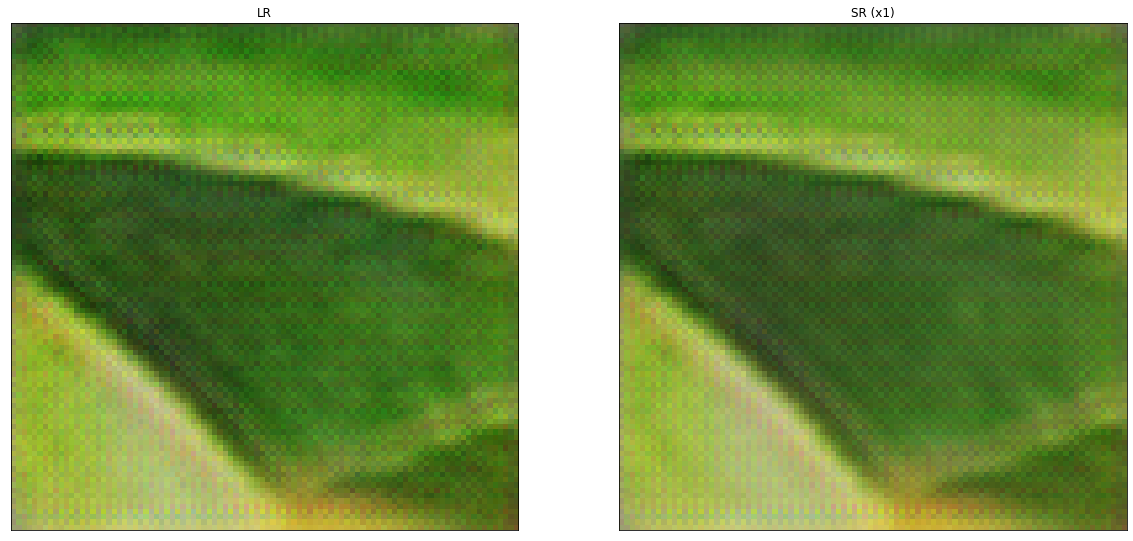

In [ ]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

import os
import numpy as np
import matplotlib.pyplot as plt
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']

  shape = tf.expand_dims(input, 0)
  interpreter.resize_tensor_input(tensor_index, shape.shape);         # change input size dynamically
  interpreter.allocate_tensors()
  
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #input_tensor[:, :] = input
  print(input_tensor.shape)
  scale, zero_point = input_details['quantization']
  
  input = np.float32(input)/255.0
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def lr2sr(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])[0]
  
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = ((scale * (output - zero_point))+1)*127.5
  

  output = tf.cast(output, tf.uint8)
  # print(output)
  return output

interpreter = tf.lite.Interpreter('/content/super-resolution/weights/srgan/srgan_quant_2.tflite')
interpreter.allocate_tensors()

dd = valid_ds.take(1)
for image, label in dd:
  lr = image[2]
  hr = label[2]


sr_raw = resolve_single(model, lr)
sr_q = lr2sr(interpreter, lr)

plot_sample(sr_q, sr_raw)


In [ ]:
psnr_raw = tf.image.psnr(sr_raw, hr, max_val=255)
psnr_quant = tf.image.psnr(sr_q, hr, max_val=255)
print(psnr_raw)
print(psnr_quant)

tf.Tensor(22.566517, shape=(), dtype=float32)
tf.Tensor(22.380426, shape=(), dtype=float32)


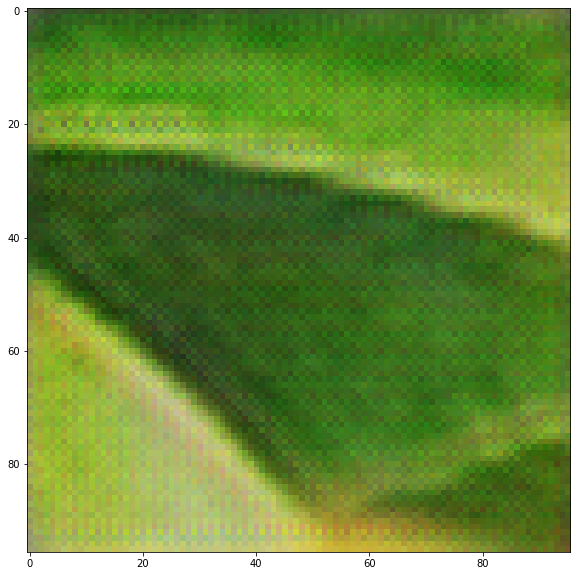

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(sr_q)

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  34283      0 --:--:-- --:--:-- --:--:-- 34283
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/

In [ ]:
! edgetpu_compiler /content/super-resolution/weights/srgan/srgan_quant_2.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 679 ms.

Input model: /content/super-resolution/weights/srgan/srgan_quant_2.tflite
Input size: 1.58MiB
Output model: srgan_quant_2_edgetpu.tflite
Output size: 497.75KiB
On-chip memory used for caching model parameters: 244.75KiB
On-chip memory remaining for caching model parameters: 7.48MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 78
Operation log: srgan_quant_2_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 70
Number of operations that will run on CPU: 8
See the operation log file

tf.Tensor(
[[[ 80  87  80]
  [102 101  91]
  [123 117 106]
  ...
  [113 117 124]
  [113 121 131]
  [ 89  97 105]]

 [[136 133 128]
  [149 142 136]
  [156 149 141]
  ...
  [121 121 121]
  [145 150 150]
  [143 151 149]]

 [[132 130 129]
  [125 118 119]
  [122 110 111]
  ...
  [ 94  90  92]
  [143 142 140]
  [169 170 168]]

 ...

 [[152 154 145]
  [154 156 151]
  [165 166 160]
  ...
  [ 58  61  67]
  [ 36  38  42]
  [ 24  26  29]]

 [[167 166 155]
  [179 175 166]
  [166 158 150]
  ...
  [ 78  83  90]
  [ 61  68  76]
  [ 47  52  58]]

 [[153 148 141]
  [152 141 140]
  [111 100 104]
  ...
  [ 91  94 101]
  [ 82  85  93]
  [ 71  75  82]]], shape=(24, 24, 3), dtype=uint8)


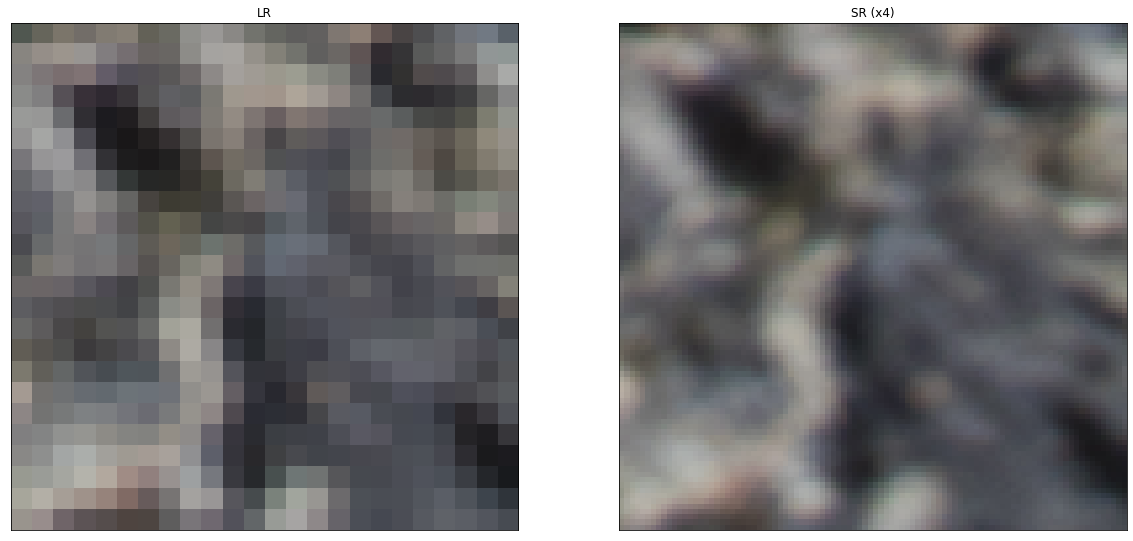

In [ ]:
#dd = train_ds.take(1)

# for image, label in dd:
#   plot_sample(image[0], label[0])
#   print(image[0])
  